copied from `dataset.jl` file in OLD\src_old

In [1]:
using TimeSeries
using FredData
using Gadfly

In [4]:
fred_api_key = "2feb6269f18df39acfd321ae549b7de3"
f = Fred(fred_api_key)

FRED API Connection
	url: https://api.stlouisfed.org/fred/
	key: 2feb6269f18df39acfd321ae549b7de3


# Function definitions

In [10]:
function get_vintage(srs, date)
    df = srs.data # might be easier with Query
    mask = df[:realtime_start] .<= date .< df[:realtime_end]
    temp = df[mask,:]
    ts = TimeArray(temp[:date].data, temp[:value].data, [srs.id])
end

function transform(ts::TimeArray, how)
    if how == :unchanged
        ts = ts
    elseif how == :log
        ts = TimeArray(ts.timestamp, log.(ts.values), ts.colnames)
    elseif how == :Δ
        ts = TimeArray(ts.timestamp[2:end], ts.values[2:end,:].-ts.values[1:end-1,:], ts.colnames)
    elseif how == :Δlog
        ts = TimeArray(ts.timestamp[2:end], log.(ts.values[2:end,:]).-log.(ts.values[1:end-1,:]), ts.colnames)
    elseif how == :Δ2log
        vals = log.(ts.values[2:end,:]).-log.(ts.values[1:end-1,:])
        ts = TimeArray(ts.timestamp[3:end], vals[2:end,:].-vals[1:end-1,:], ts.colnames)
    else
        throw(error)
    end
    return ts
end

function merge_timeseries(array)
    merged_ts = merge(array[1], array[2], :outer)
    for ts=array[3:end]
         merged_ts = merge(merged_ts, ts, :outer)
    end
    return merged_ts
end

merge_timeseries (generic function with 1 method)

# I. GDP

In [12]:
vintage_date = Date(2017,12,15)

2017-12-15

In [13]:
GDP = get_data(f, "GDPC1"; realtime_start="1999-12-31")
gdp = get_vintage(GDP, vintage_date)
gdp = TimeArray(gdp.timestamp.+Dates.Month(2), gdp["GDPC1"].values, gdp.colnames) # so that quarterly value is assigned to last month
gdp = transform(gdp, :Δlog)
gdp = from(gdp, Date(1990, 1, 1))

111x1 TimeSeries.TimeArray{Float64,2,Date,Array{Float64,2}} 1990-03-01 to 2017-09-01
│            │ GDPC1   │
├────────────┼─────────┤
│ 1990-03-01 │ 0.0109  │
│ 1990-06-01 │ 0.0039  │
│ 1990-09-01 │ 0.0002  │
│ 1990-12-01 │ -0.0086 │
│ 1991-03-01 │ -0.0047 │
│ 1991-06-01 │ 0.0077  │
│ 1991-09-01 │ 0.0048  │
│ 1991-12-01 │ 0.0044  │
│ 1992-03-01 │ 0.0117  │
│ 1992-06-01 │ 0.011   │
│ 1992-09-01 │ 0.0097  │
│ 1992-12-01 │ 0.01    │
   ⋮
│ 2015-03-01 │ 0.008   │
│ 2015-06-01 │ 0.0068  │
│ 2015-09-01 │ 0.004   │
│ 2015-12-01 │ 0.0012  │
│ 2016-03-01 │ 0.0014  │
│ 2016-06-01 │ 0.0055  │
│ 2016-09-01 │ 0.0069  │
│ 2016-12-01 │ 0.0044  │
│ 2017-03-01 │ 0.0031  │
│ 2017-06-01 │ 0.0075  │
│ 2017-09-01 │ 0.0081  │

# II. Monthly predictors

In [36]:
# TODO: expand set of predictors

# transformations as suggested in FRED-MD
predictors1 = Dict(
    "INDPRO"   => :Δlog,      # Industrial Production Index
    "TCU"      => :Δ,         # Capacity Utilization: Total Industry
    "UNRATE"   => :Δ,         #
    "PAYEMS"   => :Δlog,      # All Employees: Total Nonfarm Payrolls
    "CPIAUCSL" => :Δ2log,     #
    "PPIACO"   => :Δ2log,     #
    "HOUST"    => :log,       #
    "PERMIT"   => :log,       #
    "FEDFUNDS" => :Δ
)

# transformations that I find it appropriate
predictors2 = Dict(
    "INDPRO"   => :Δlog,      # Industrial Production Index
    "TCU"      => :Δ,         # Capacity Utilization: Total Industry
    "UNRATE"   => :Δ,         #
    "PAYEMS"   => :Δlog,      # All Employees: Total Nonfarm Payrolls
    "CPIAUCSL" => :Δlog,      #
    "PPIACO"   => :Δlog,      #
    "HOUST"    => :Δlog,      #
    "PERMIT"   => :Δlog,      #
)

predictors = predictors2

# TODO: unit root test ?

dataset = Dict()
for id in keys(predictors)
    dataset[id] = get_data(f, id; realtime_start="1999-12-31")
end

# III. Joint dataset

In [37]:
data = []

for id in keys(predictors)
    new_series = get_vintage(dataset[id], vintage_date)
    new_series = transform(new_series, predictors[id])
    new_series = from(new_series, Date(1990, 1, 1))
    data = push!(data, new_series)
end

data = unshift!(data, gdp)

data = merge_timeseries(data)

335x9 TimeSeries.TimeArray{Float64,2,Date,Array{Float64,2}} 1990-01-01 to 2017-11-01
│            │ GDPC1   │ UNRATE │ CPIAUCSL │ TCU   │ PAYEMS  │ INDPRO  │
├────────────┼─────────┼────────┼──────────┼───────┼─────────┼─────────┤
│ 1990-01-01 │ NaN     │ 0.0    │ 0.0095   │ -0.7  │ 0.0031  │ -0.0067 │
│ 1990-02-01 │ NaN     │ -0.1   │ 0.0039   │ 0.6   │ 0.0023  │ 0.01    │
│ 1990-03-01 │ 0.0109  │ -0.1   │ 0.0047   │ 0.2   │ 0.002   │ 0.005   │
│ 1990-04-01 │ NaN     │ 0.2    │ 0.0023   │ -0.2  │ 0.0004  │ -0.0012 │
│ 1990-05-01 │ NaN     │ 0.0    │ 0.0016   │ -0.1  │ 0.0014  │ 0.0016  │
│ 1990-06-01 │ 0.0039  │ -0.2   │ 0.0062   │ 0.1   │ 0.0002  │ 0.0033  │
│ 1990-07-01 │ NaN     │ 0.3    │ 0.0046   │ -0.2  │ -0.0003 │ -0.0011 │
│ 1990-08-01 │ NaN     │ 0.2    │ 0.0084   │ 0.1   │ -0.002  │ 0.0031  │
│ 1990-09-01 │ 0.0002  │ 0.2    │ 0.0068   │ 0.0   │ -0.0008 │ 0.0014  │
│ 1990-10-01 │ NaN     │ 0.0    │ 0.0068   │ -0.8  │ -0.0015 │ -0.0076 │
│ 1990-11-01 │ NaN     │ 0.3    │ 0.002

# IV. Plots

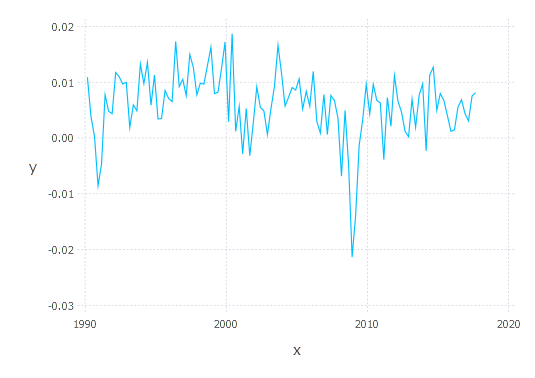

In [38]:
plot(x=gdp.timestamp, y=gdp["GDPC1"].values, Geom.line())

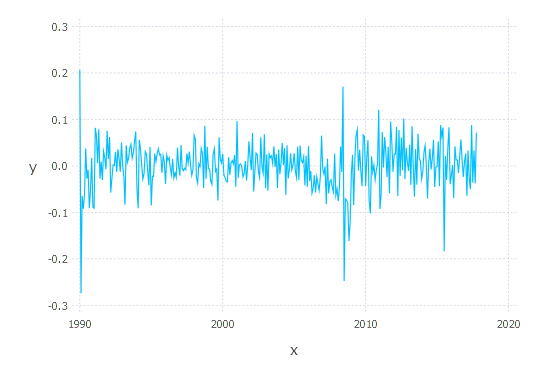

In [39]:
plot(x=data.timestamp, y=data["PERMIT"].values, Geom.line)

In [40]:
gdp

111x1 TimeSeries.TimeArray{Float64,2,Date,Array{Float64,2}} 1990-03-01 to 2017-09-01
│            │ GDPC1   │
├────────────┼─────────┤
│ 1990-03-01 │ 0.0109  │
│ 1990-06-01 │ 0.0039  │
│ 1990-09-01 │ 0.0002  │
│ 1990-12-01 │ -0.0086 │
│ 1991-03-01 │ -0.0047 │
│ 1991-06-01 │ 0.0077  │
│ 1991-09-01 │ 0.0048  │
│ 1991-12-01 │ 0.0044  │
│ 1992-03-01 │ 0.0117  │
│ 1992-06-01 │ 0.011   │
│ 1992-09-01 │ 0.0097  │
│ 1992-12-01 │ 0.01    │
   ⋮
│ 2015-03-01 │ 0.008   │
│ 2015-06-01 │ 0.0068  │
│ 2015-09-01 │ 0.004   │
│ 2015-12-01 │ 0.0012  │
│ 2016-03-01 │ 0.0014  │
│ 2016-06-01 │ 0.0055  │
│ 2016-09-01 │ 0.0069  │
│ 2016-12-01 │ 0.0044  │
│ 2017-03-01 │ 0.0031  │
│ 2017-06-01 │ 0.0075  │
│ 2017-09-01 │ 0.0081  │